In [1]:
import pandas as pd
ClinicalTrial = pd.read_csv('/content/Clinicaltrial.csv')
Grant = pd.read_csv('/content/Grant.csv',  error_bad_lines=False)
Pubmed = pd.read_csv('/content/Pubmed.csv', on_bad_lines='skip')# on_bad_lines='skip') #error_bad_lines=False
ClinicalTrial = ClinicalTrial.applymap(lambda x: str(x).replace('"', ''))
Grant = Grant.applymap(lambda x: str(x).replace('"', ''))
Pubmed = Pubmed.applymap(lambda x: str(x).replace('"', ''))
print(ClinicalTrial.shape[0],Grant.shape[0],Pubmed.shape[0])

<ipython-input-1-1d23665e6ded>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  Grant = pd.read_csv('/content/Grant.csv',  error_bad_lines=False)


8436 22000 34023


In [6]:
display('ClinicalTrial:',ClinicalTrial.columns)
display('Grant:',Grant.columns)
display('Pubmed:',Pubmed.columns)

'ClinicalTrial:'

Index(['i.OfficialName', 'i.OfficialAffiliation', 'c. BriefTitle',
       'c.OfficialTitle', 'c.BriefSummary', 'c.NCTId', 'l.LocationCity',
       'l.LocationCountry', 'l.LocationFacility', 'concatenatedInterventions'],
      dtype='object')

'Grant:'

Index(['pi.pi_name', 'pi.org_name', 'p.title', 'p.application_id',
       'p.abstract', 'p.terms', 'co.core_project_num'],
      dtype='object')

'Pubmed:'

Index(['a.fullName', 'ar.title', 'ar.affiliation', 'ar.pubmed_id',
       'ar.abstractText', 'concatenatedKeywords', 'concatenatedMeshterms'],
      dtype='object')

In [7]:
ClinicalTrial = ClinicalTrial[ClinicalTrial['i.OfficialName'].apply(lambda x: x.strip()) != ""]
ClinicalTrial = ClinicalTrial.drop_duplicates()
ClinicalTrial.reset_index(drop=True, inplace=True)

Grant = Grant[Grant['pi.pi_name'].apply(lambda x: x.strip()) != ""]
Grant = Grant.drop_duplicates()
Grant.reset_index(drop=True, inplace=True)

Pubmed = Pubmed[Pubmed['a.fullName'].apply(lambda x: x.strip()) != ""]
Pubmed = Pubmed.drop_duplicates()
Pubmed.reset_index(drop=True, inplace=True)
print(ClinicalTrial.shape[0],Grant.shape[0],Pubmed.shape[0])

8422 11343 33707


In [2]:
def find_coauthors(df,name,affliation,title):
    coauthors_dict = {}
    connection={}
    for index_a, row_a in df.iterrows():
        for index_b, row_b in df.iterrows():
            if index_a != index_b and row_a[title] == row_b[title]:
                key_a =(row_a[name], row_a[affliation])
                key_b = (row_b[name], row_b[affliation])

                if key_a !=key_b  and key_b[0].strip() !=''  and key_a[0].strip() !='':
                  if key_a not in coauthors_dict: coauthors_dict[key_a] = []
                  if key_b not in coauthors_dict: coauthors_dict[key_b] = []

                  if key_b not in coauthors_dict[key_a]:  coauthors_dict[key_a].append(key_b)
                  if key_a not in coauthors_dict[key_b]:  coauthors_dict[key_b].append(key_a)
                  if   (key_a,key_b) not in connection:   connection[(key_a,key_b)]=1
                  else:                                   connection[(key_a,key_b)]+= connection[(key_a,key_b)]


    return coauthors_dict,connection

a,a1=find_coauthors(ClinicalTrial[:2000],'i.OfficialName','i.OfficialAffiliation','c.NCTId')
b,b1=find_coauthors(Grant[:2000],'pi.pi_name','pi.org_name','p.application_id')
c,c1=find_coauthors(Pubmed[:2000],'a.fullName','ar.affiliation','ar.pubmed_id')

In [3]:
from collections import defaultdict

# Combine dictionaries
combined_dict = defaultdict(set)

# Function to merge values for common keys
def merge_dicts(d1, d2):
    for key, values in d1.items():
        combined_dict[key].update(values)
    for key, values in d2.items():
        combined_dict[key].update(values)
    return combined_dict

# Merge dictionaries
combined_dict = merge_dicts(a, b)
combined_dict = merge_dicts(combined_dict, c)

def sum_dicts(dict1, dict2):
    result_dict = {}
    all_keys = set(dict1.keys()) | set(dict2.keys())
    for key in all_keys:
        value1 = dict1.get(key, 0)
        value2 = dict2.get(key, 0)
        result_dict[key] = value1 + value2
    return result_dict
# Merge dictionaries
combined_dict1 = sum_dicts(a1, b1)
result_dict1 = sum_dicts(combined_dict1, c1)

# Convert sets back to lists if needed
result_dict = {key: list(values) for key, values in combined_dict.items()}


In [4]:
for key in result_dict1:
    result_dict1[key] = result_dict1[key] %1000

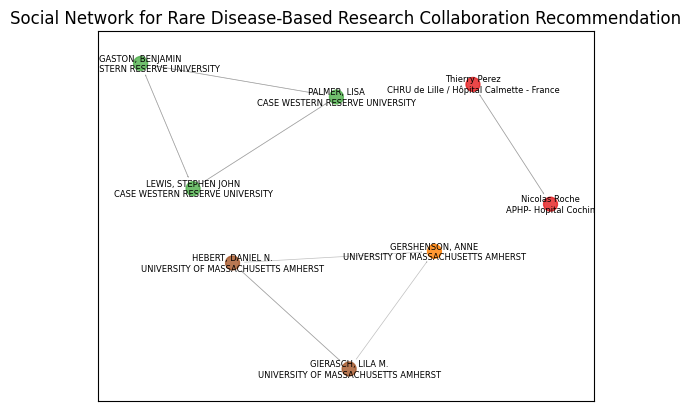

In [31]:
import networkx as nx
import matplotlib.pyplot as plt

# Your provided dictionary
data =  {('Nicolas Roche',
  'APHP- Hopital Cochin'): [('Thierry Perez',
   'CHRU de Lille / Hôpital Calmette - France')],
 ('Thierry Perez',
  'CHRU de Lille / Hôpital Calmette - France'): [('Nicolas Roche',
   'APHP- Hopital Cochin')],
 ('PALMER, LISA',
  'CASE WESTERN RESERVE UNIVERSITY'): [('GASTON, BENJAMIN',
   'CASE WESTERN RESERVE UNIVERSITY'), ('LEWIS, STEPHEN JOHN',
   'CASE WESTERN RESERVE UNIVERSITY')],
 ('LEWIS, STEPHEN JOHN',
  'CASE WESTERN RESERVE UNIVERSITY'): [('PALMER, LISA',
   'CASE WESTERN RESERVE UNIVERSITY'), ('GASTON, BENJAMIN',
   'CASE WESTERN RESERVE UNIVERSITY')],
 ('GASTON, BENJAMIN',
  'CASE WESTERN RESERVE UNIVERSITY'): [('PALMER, LISA',
   'CASE WESTERN RESERVE UNIVERSITY'), ('LEWIS, STEPHEN JOHN',
   'CASE WESTERN RESERVE UNIVERSITY')],
 ('HEBERT, DANIEL N.',
  'UNIVERSITY OF MASSACHUSETTS AMHERST'): [('GIERASCH, LILA M.',
   'UNIVERSITY OF MASSACHUSETTS AMHERST'), ('GERSHENSON, ANNE',
   'UNIVERSITY OF MASSACHUSETTS AMHERST')],
 ('GIERASCH, LILA M.',
  'UNIVERSITY OF MASSACHUSETTS AMHERST'): [('GERSHENSON, ANNE',
   'UNIVERSITY OF MASSACHUSETTS AMHERST'), ('HEBERT, DANIEL N.',
   'UNIVERSITY OF MASSACHUSETTS AMHERST')]}
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges from the dictionary
for nodes, edges in data.items():
    G.add_node(nodes[0], institution=nodes[1])
    for edge in edges:
        G.add_node(edge[0], institution=edge[1])
        G.add_edge(nodes[0], edge[0])

# Determine connected components
components = list(nx.strongly_connected_components(G))
# Assign colors to nodes based on connected components
color_map = {}
for i, component in enumerate(components):
    for node in component:
        color_map[node] = plt.cm.Set1(i / len(components))  # Set1 colormap for variety

# Draw the graph with enhanced styling
#fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size

#pos = nx.spring_layout(G, seed=42, k=1, iterations=1)
pos = nx.kamada_kawai_layout(G)

# Node styling with specified colors
node_colors = [color_map[node] for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors, alpha=0.8)
# Edge styling
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=1)
# Label styling
labels = {node: f"{node}\n{G.nodes[node]['institution']}" for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=6, font_color='black')
# Add a title
plt.title("Social Network for Rare Disease-Based Research Collaboration Recommendation")
# Show the plot
plt.show()

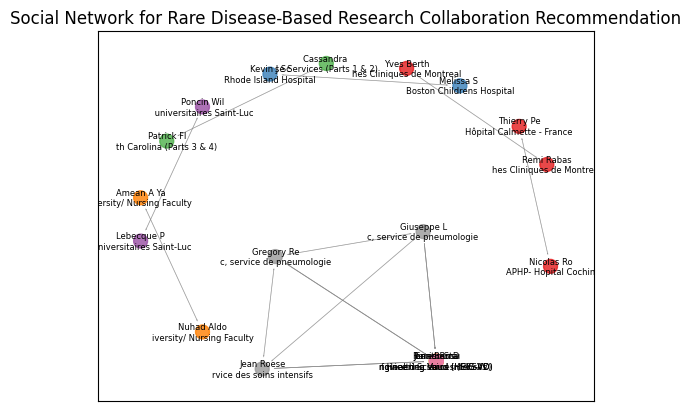

In [33]:
data= dict(list(combined_dict.items())[:15])
G = nx.DiGraph()

# Add nodes and edges from the dictionary
for nodes, edges in data.items():
    G.add_node(nodes[0], institution=nodes[1])
    for edge in edges:
        G.add_node(edge[0], institution=edge[1])
        G.add_edge(nodes[0], edge[0])

# Determine connected components
components = list(nx.strongly_connected_components(G))
# Assign colors to nodes based on connected components
color_map = {}
for i, component in enumerate(components):
    for node in component:
        color_map[node] = plt.cm.Set1(i / len(components))  # Set1 colormap for variety

# Draw the graph with enhanced styling
#fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size

#pos = nx.spring_layout(G, seed=42, k=1, iterations=1)
pos = nx.kamada_kawai_layout(G)

# Node styling with specified colors
node_colors = [color_map[node] for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors, alpha=0.8)
# Edge styling
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=1)
# Label styling
labels = {node: f"{node[:10]}\n{G.nodes[node]['institution'][-25:]}" for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=6, font_color='black')
# Add a title
plt.title("Social Network for Rare Disease-Based Research Collaboration Recommendation")
# Show the plot
plt.show()

In [7]:
import networkx as nx
layout_algorithms = [
    nx.circular_layout,
    nx.random_layout,
    nx.spring_layout,
    nx.spectral_layout,
    nx.shell_layout,
    nx.bipartite_layout,
    nx.planar_layout,
    nx.fruchterman_reingold_layout,
    nx.kamada_kawai_layout
]

In [16]:
data = {
    ('jdhssk', 'kshsls'): [('jdworiesk', 'ksfdkwjr'), ('jdkwej', 'nbooools of school'), ('jtermsk', 'kswpqke')]
}
# Iterate over the original dictionary
def modified_name(data,n,m):
  modified_data = {}
  for key, values in data.items():
    # Modify the key to include only the first 10 characters of each part
    modified_key = tuple(part[n:m] for part in key)
    # Modify each value to include only the first 10 characters of each part
    modified_values = [(value[0][n:m], value[1][n:m]) for value in values]
    # Update the modified data dictionary
    modified_data[modified_key] = modified_values
  return   modified_data
modified_name(data,0,2)

{('jd', 'ks'): [('jd', 'ks'), ('jd', 'nb'), ('jt', 'ks')]}

In [46]:
filtered_items = {key: value for key, value in result_dict1.items() if value in [3,4,5]}
components_list = []
for key in filtered_items.keys():
    components_list.extend(key)
#components_list
Small_sample = {key: value for key, value in combined_dict.items() if key in components_list}

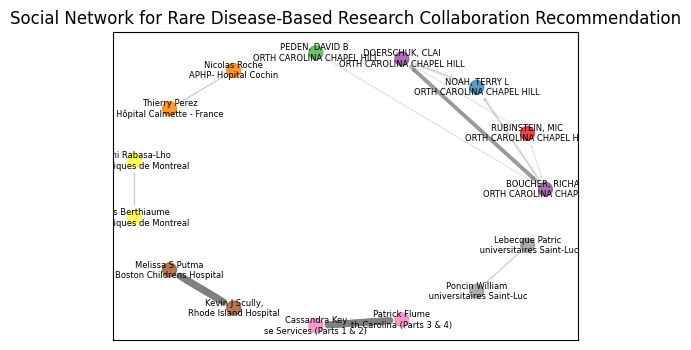

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

Small_sample.update(dict(list(combined_dict.items())[:5]))
data=Small_sample
#data= dict(list(combined_dict.items())[0:21])
#data=modified_name(data,0,20)


G = nx.DiGraph()
XCS = result_dict1
# Add nodes and edges from the dictionary
for nodes, edges in data.items():
    G.add_node(nodes[0], institution=nodes[1])
    for edge in edges:
        G.add_node(edge[0], institution=edge[1])
        weight = XCS.get((nodes,edge), 1)  # Default weight is 1 if not found in XCS
        G.add_edge(nodes[0], edge[0], weight=weight)  # Add weight to the edge


# Determine connected components
components = list(nx.strongly_connected_components(G))

# Assign colors to nodes based on connected components
color_map = {}
for i, component in enumerate(components):
    for node in component:
        color_map[node] = plt.cm.Set1(i / len(components))  # Set1 colormap for variety

plt.figure(figsize=(6, 4))
#ax = plt.subplot(111)


# Draw the graph with enhanced styling
pos = layout_algorithms[0](G)

# Node styling with specified colors
node_colors = [color_map[node] for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors, alpha=0.8)

# Draw edges with variable width and alpha based on weights
# Draw edges with variable width and alpha based on weights
edge_weights = nx.get_edge_attributes(G, 'weight')

# Check if all weights are the same
if len(set(edge_weights.values())) == 1:
    max_weight = min_weight = next(iter(edge_weights.values()))
else:
    max_weight = max(edge_weights.values())
    min_weight = min(edge_weights.values())

for edge, weight in edge_weights.items():
    if max_weight != min_weight:  # Avoid division by zero if all weights are the same
        normalized_weight = (weight - min_weight) / (max_weight - min_weight)  # Normalize weight between 0 and 1
    else:
        normalized_weight = 0.5  # Set normalized weight to 0.5 if all weights are the same
    width = 1 + 4 * normalized_weight  # Adjust width based on normalized weight
    alpha = 0.2 + 0.8 * normalized_weight  # Adjust alpha (transparency) based on normalized weight
    nx.draw_networkx_edges(G, pos, edgelist=[edge], width=width, alpha=alpha, edge_color='gray', arrowsize=1)

# Label styling
#labels = {node: f"{node}\n{G.nodes[node]['institution']}" for node in G.nodes}
labels = {node: f"{node[:15]}\n{G.nodes[node]['institution'][-25:]}" for node in G.nodes}

nx.draw_networkx_labels(G, pos, labels=labels, font_size=6, font_color='black')

# Add a title
plt.title("Social Network for Rare Disease-Based Research Collaboration Recommendation")

# Show the plot
plt.show()

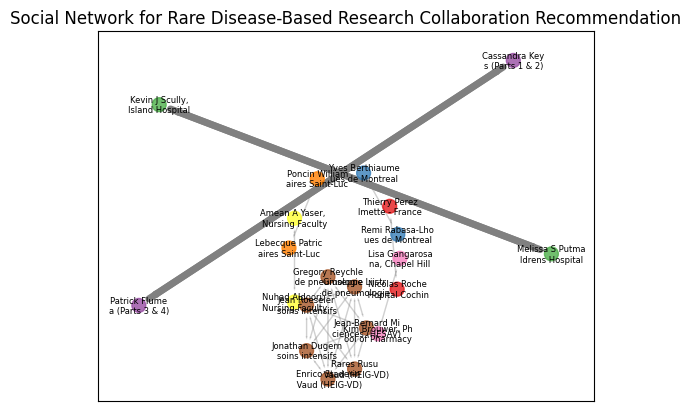

In [22]:
pos = layout_algorithms[-1](G)

# Node styling with specified colors
node_colors = [color_map[node] for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors, alpha=0.8)

# Draw edges with variable width and alpha based on weights
# Draw edges with variable width and alpha based on weights
edge_weights = nx.get_edge_attributes(G, 'weight')

# Check if all weights are the same
if len(set(edge_weights.values())) == 1:
    max_weight = min_weight = next(iter(edge_weights.values()))
else:
    max_weight = max(edge_weights.values())
    min_weight = min(edge_weights.values())

for edge, weight in edge_weights.items():
    if max_weight != min_weight:  # Avoid division by zero if all weights are the same
        normalized_weight = (weight - min_weight) / (max_weight - min_weight)  # Normalize weight between 0 and 1
    else:
        normalized_weight = 0.5  # Set normalized weight to 0.5 if all weights are the same
    width = 1 + 4 * normalized_weight  # Adjust width based on normalized weight
    alpha = 0.2 + 0.8 * normalized_weight  # Adjust alpha (transparency) based on normalized weight
    nx.draw_networkx_edges(G, pos, edgelist=[edge], width=width, alpha=alpha, edge_color='gray', arrowsize=1)

# Label styling
#labels = {node: f"{node}\n{G.nodes[node]['institution']}" for node in G.nodes}
labels = {node: f"{node[:15]}\n{G.nodes[node]['institution'][-15:]}" for node in G.nodes}

nx.draw_networkx_labels(G, pos, labels=labels, font_size=6, font_color='black')

# Add a title
plt.title("Social Network for Rare Disease-Based Research Collaboration Recommendation")

# Show the plot
plt.show()

In [55]:
!pip install python-louvain

<ipython-input-79-868006fcc459>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)  # Set color map
<ipython-input-79-868006fcc459>:26: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=0.02)


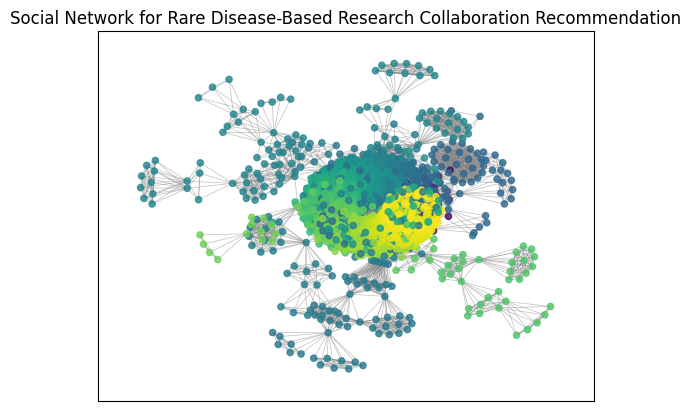

In [79]:
import networkx as nx
import community
from community import community_louvain
import matplotlib.pyplot as plt


# Create a directed graph
G = nx.Graph()

# Add nodes and edges from the dictionary
for nodes, edges in combined_dict.items():
    G.add_node(nodes[0], institution=nodes[1])
    #G.add_node(nodes[0], institution=nodes[1])
    for edge in edges:
        G.add_node(edge[0], institution=edge[1])
        G.add_edge(nodes[0], edge[0])

# Detect communities using Louvain method
partition = community_louvain.best_partition(G)

# Draw the graph with nodes colored by their community
pos = nx.kamada_kawai_layout(G)
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)  # Set color map
#nx.draw(G, pos, node_color=[cmap(partition[node]) for node in G.nodes()], with_labels=None)
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=[cmap(partition[node]) for node in G.nodes()], alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=0.02)
plt.title("Social Network for Rare Disease-Based Research Collaboration Recommendation")

plt.show()

<ipython-input-90-615f987bd557>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)  # Set color map
<ipython-input-90-615f987bd557>:23: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=0.02)


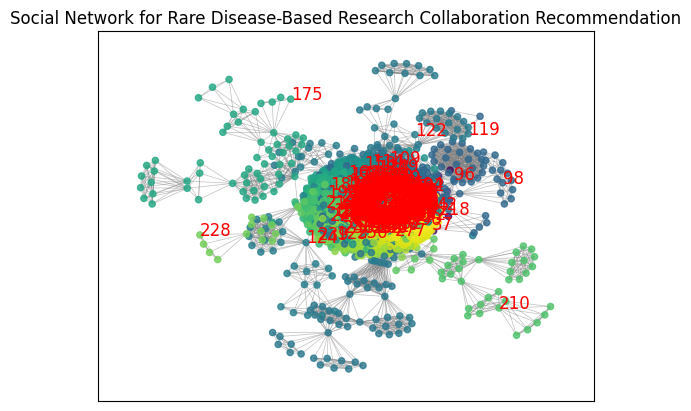

In [90]:
import networkx as nx
import community
from community import community_louvain
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.Graph()

# Add nodes and edges from the dictionary
for nodes, edges in combined_dict.items():
    G.add_node(nodes[0], institution=nodes[1])
    for edge in edges:
        G.add_node(edge[0], institution=edge[1])
        G.add_edge(nodes[0], edge[0])

# Detect communities using Louvain method
partition = community_louvain.best_partition(G)

# Draw the graph with nodes colored by their community
pos = nx.kamada_kawai_layout(G)
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)  # Set color map
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=[cmap(partition[node]) for node in G.nodes()], alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=0.02)

# Label one node per community with its community partition value near its community
community_labels = {}
for node, community_id in partition.items():
    if community_id not in community_labels:
        community_labels[community_id] = node

for community_id, node in community_labels.items():
    x, y = pos[node]
    plt.text(x, y, str(community_id), fontsize=12, color='red')

plt.title("Social Network for Rare Disease-Based Research Collaboration Recommendation")
plt.show()



In [ ]:
top_communities=[19,13,57,96,98,119,122, 124,175,210,228]

In [169]:
display('ClinicalTrial:',ClinicalTrial.columns)
display('Grant:',Grant.columns)
display('Pubmed:',Pubmed.columns)

'ClinicalTrial:'

Index(['i.OfficialName', 'i.OfficialAffiliation', 'c. BriefTitle',
       'c.OfficialTitle', 'c.BriefSummary', 'c.NCTId', 'l.LocationCity',
       'l.LocationCountry', 'l.LocationFacility', 'concatenatedInterventions',
       'name'],
      dtype='object')

'Grant:'

Index(['pi.pi_name', 'pi.org_name', 'p.title', 'p.application_id',
       'p.abstract', 'p.terms', 'co.core_project_num', 'name'],
      dtype='object')

'Pubmed:'

Index(['a.fullName', 'ar.title', 'ar.affiliation', 'ar.pubmed_id',
       'ar.abstractText', 'concatenatedKeywords', 'concatenatedMeshterms',
       'name'],
      dtype='object')

In [63]:
import networkx as nx
import community
from community import community_louvain
import matplotlib.pyplot as plt


# Create a directed graph
G = nx.Graph()

# Add nodes and edges from the dictionary
for nodes, edges in combined_dict.items():
    G.add_node(nodes)
    for edge in edges:
        G.add_node(edge)
        G.add_edge(nodes, edge)

# Detect communities using Louvain method
partition = community_louvain.best_partition(G)
data_table = pd.DataFrame(partition.items(), columns=['Node', 'Community'])
data_table

,Node,Community
0,"(Nicolas Roche, APHP- Hopital Cochin)",0
1,"(Thierry Perez, CHRU de Lille / Hôpital Calmet...",0
2,"(Remi Rabasa-Lhoret, Institut de Recherches Cl...",1
3,"(Yves Berthiaume, Institut de Recherches Clini...",1
4,"(Melissa S Putman, Boston Childrens Hospital)",2
...,...,...
2224,"(Durand M, Pôle thorax et vaisseaux, clinique ...",9
2225,"(Claustre J, Pôle thorax et vaisseaux, cliniqu...",9
2226,"(Pison C, Pôle thorax et vaisseaux, clinique u...",9
2227,"(Gheerbrant H, Pôle thorax et vaisseaux, clini...",9


In [64]:
ClinicalTrial['name'] = ClinicalTrial.apply(lambda row: (row['i.OfficialName'], row['i.OfficialAffiliation']), axis=1)
Grant['name'] = Grant.apply(lambda row: (row['pi.pi_name'], row['pi.org_name']), axis=1)
Pubmed['name'] = Pubmed.apply(lambda row: (row['a.fullName'], row['ar.affiliation']), axis=1)


In [65]:
ClinicalTrial['c.BriefSummary']=ClinicalTrial['c.OfficialTitle']+ClinicalTrial['concatenatedInterventions']+ClinicalTrial['c.BriefSummary']
Grant['c.BriefSummary']=Grant['p.title']+Grant['p.terms']+Grant['p.abstract']
Pubmed['ar.abstractText']=Pubmed['ar.title']+Pubmed['concatenatedKeywords']+Pubmed['concatenatedMeshterms']+Pubmed['ar.abstractText']

df1=ClinicalTrial[['i.OfficialName',  'c.BriefSummary', 'i.OfficialAffiliation','name']]
df2=Grant[['pi.pi_name', 'p.abstract', 'pi.org_name','name']]
df3=Pubmed[['a.fullName',  'ar.abstractText', 'ar.affiliation','name']]
# Rename columns to avoid conflicts
df1.columns = ['PI','Abstract', 'Location','name']
df2.columns = ['PI','Abstract', 'Location','name']
df3.columns = ['PI','Abstract', 'Location','name']
#df2['Location']=  df2['locationCity'] +' , '+df2['Location']
result_df = pd.concat([df1, df2, df3])
#result_df = pd.concat([df1,  df3])
result_df=result_df.drop_duplicates()

In [66]:
#merged_data1 = pd.merge(data_table, ClinicalTrial, left_on='Node', right_on='name', how='inner')
#merged_data2 = pd.merge(data_table, Grant, left_on='Node', right_on='name', how='inner')
#merged_data3 = pd.merge(data_table, Pubmed, left_on='Node', right_on='name', how='inner')
#concatenated_data = pd.concat([merged_data1, merged_data2, merged_data3], axis=0)
#concatenated_data = concatenated_data.drop_duplicates(subset=['name'])
#concatenated_data.reset_index(drop=True, inplace=True)

merged_data1 = pd.merge(data_table, result_df, left_on='Node', right_on='name', how='inner')
concatenated_data = merged_data1.drop_duplicates(subset=['name'])
concatenated_data.reset_index(drop=True, inplace=True)
concatenated_data=concatenated_data.drop(['name'],axis=1)

In [67]:
concatenated_data.head()

,Node,Community,PI,Abstract,Location
0,"(Nicolas Roche, APHP- Hopital Cochin)",0,Nicolas Roche,Development of a New Tool for Dyspnea Measurem...,APHP- Hopital Cochin
1,"(Thierry Perez, CHRU de Lille / Hôpital Calmet...",0,Thierry Perez,Development of a New Tool for Dyspnea Measurem...,CHRU de Lille / Hôpital Calmette - France
2,"(Remi Rabasa-Lhoret, Institut de Recherches Cl...",1,Remi Rabasa-Lhoret,Effects of a Program of Aerobic and Resistance...,Institut de Recherches Cliniques de Montreal
3,"(Yves Berthiaume, Institut de Recherches Clini...",1,Yves Berthiaume,Effects of a Program of Aerobic and Resistance...,Institut de Recherches Cliniques de Montreal
4,"(Melissa S Putman, Boston Childrens Hospital)",2,Melissa S Putman,The Effects of a Low Glycemic Load Diet on Dys...,Boston Childrens Hospital


In [ ]:
from transformers import pipeline
qa_pipeline = pipeline("question-answering", model="bert-large-uncased-whole-word-masking-finetuned-squad")

In [77]:
def ask_question(context):
    # Load the pretrained question-answering model
    # Provide the context and question to the model
    answer = qa_pipeline(question="what are the main technical skills?", context=context)

    return answer['answer']
def extract_topics_lda_grouped(df):
    # Group by 'Topic' and sum 'Abstract'
    grouped_df = df.groupby('Community')['Abstract'].sum().reset_index()

    # Initialize an empty list to store the results for each topic
    results = dict()
    # Apply LDA to each grouped abstract
    n=1
    for index, row in grouped_df.iterrows():
      if n <12:
        community = row['Community']
        abstract = row['Abstract']

        # Tokenize and apply LDA
        topics_found = ask_question(abstract)

        # Append the result to the list
        results[community]= topics_found
        print(community,topics_found)
        n+=1
    return results
# Function call
grouped_results = extract_topics_lda_grouped(concatenated_data)

# Display results
#print(grouped_results)

0 psychometric evaluation of a self-administered dyspnea questionnaire
1 muscle strength and endurance
2 continuous glucose monitors
3 Safety, Tolerability, and Pharmacokinetics
4 discover safe drugs that correct the basic defect and prevent lung disease
5 provide findings that will assist in the interpretation of the trial results
6 Analysis of Inhaled and Lost Doses
7 Specific enzymes
8 Procedures
9 Outlook and conclusion
10 on-demand webinars or in-service by trained site educators


In [68]:
concatenated_data['Community'].max()

371

In [ ]:
import networkx as nx
import community
from community import community_louvain
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.Graph()

# Add nodes and edges from the dictionary
for nodes, edges in combined_dict.items():
    G.add_node(nodes[0], institution=nodes[1])
    for edge in edges:
        G.add_node(edge[0], institution=edge[1])
        G.add_edge(nodes[0], edge[0])

# Detect communities using Louvain method
partition = community_louvain.best_partition(G)

<ipython-input-99-5bb2ede75ed8>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)  # Set color map
<ipython-input-99-5bb2ede75ed8>:18: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=0.02)


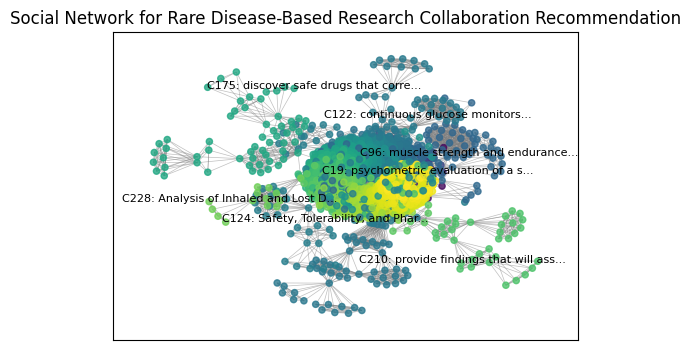

In [99]:
# Calculate the size of each community
plt.figure(figsize=(6, 4))


community_sizes = {}
for node, community_id in partition.items():
    if community_id not in community_sizes:
        community_sizes[community_id] = 0
    community_sizes[community_id] += 1

# Sort communities by size and get the top 10 largest communities
top_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)[10:20]
top_communities=[19,96,122, 124,175,210,228]
# Draw the graph with nodes colored by their community
pos = nx.kamada_kawai_layout(G)
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)  # Set color map
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=[cmap(partition[node]) for node in G.nodes()], alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=0.02)
n=0
# Label the top 10 largest communities with their community partition value near their community
for community_id in top_communities:
    for node, cid in partition.items():
        if cid == community_id:
            x, y = pos[node]
            if community_id in [124]:
              plt.text(x-0.4, y-0.1, 'C'+str(community_id)+': '+grouped_results[n][:30]+'...', fontsize=8, color='black')
            elif community_id in [210]:
               plt.text(x-0.6, y, 'C'+str(community_id)+': '+grouped_results[n][:30]+'...', fontsize=8, color='black')
            else:
              plt.text(x-0.4, y, 'C'+str(community_id)+': '+grouped_results[n][:30]+'...', fontsize=8, color='black')
            n+=1
            break

plt.title("Social Network for Rare Disease-Based Research Collaboration Recommendation")
plt.show()

<ipython-input-104-16e69584c5ca>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)  # Set color map
<ipython-input-104-16e69584c5ca>:18: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=0.02)


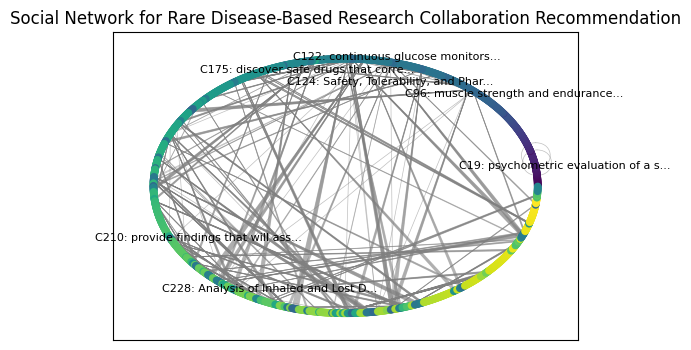

In [104]:
# Calculate the size of each community
plt.figure(figsize=(6, 4))


community_sizes = {}
for node, community_id in partition.items():
    if community_id not in community_sizes:
        community_sizes[community_id] = 0
    community_sizes[community_id] += 1

# Sort communities by size and get the top 10 largest communities
top_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)[10:20]
top_communities=[19,96,122, 124,175,210,228]
# Draw the graph with nodes colored by their community
pos = layout_algorithms[0](G)
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)  # Set color map
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=[cmap(partition[node]) for node in G.nodes()], alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=0.02)
n=0
# Label the top 10 largest communities with their community partition value near their community
for community_id in top_communities:
    for node, cid in partition.items():
        if cid == community_id:
            x, y = pos[node]
            if community_id in [124]:
              plt.text(x-0.4, y-0.2, 'C'+str(community_id)+': '+grouped_results[n][:30]+'...', fontsize=8, color='black')
            elif community_id in [175]:
               plt.text(x-0.6, y-0.1, 'C'+str(community_id)+': '+grouped_results[n][:30]+'...', fontsize=8, color='black')
            else:
              plt.text(x-0.4, y, 'C'+str(community_id)+': '+grouped_results[n][:30]+'...', fontsize=8, color='black')
            n+=1
            break

plt.title("Social Network for Rare Disease-Based Research Collaboration Recommendation")
plt.show()

In [87]:
top_communities

[96, 125, 282, 109, 112, 127, 132, 138, 153, 221]

<ipython-input-106-3582c3e78a98>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_communities)
<ipython-input-106-3582c3e78a98>:32: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=0.02)


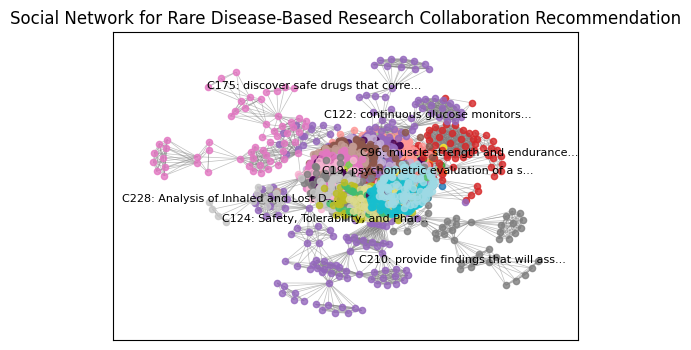

In [106]:
# Calculate the size of each community
plt.figure(figsize=(6, 4))


community_sizes = {}
for node, community_id in partition.items():
    if community_id not in community_sizes:
        community_sizes[community_id] = 0
    community_sizes[community_id] += 1

# Sort communities by size and get the top 10 largest communities
top_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)[10:20]
top_communities=[19,96,122, 124,175,210,228]
# Draw the graph with nodes colored by their community
pos = layout_algorithms[-1](G)
#cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)  # Set color map
#nx.draw_networkx_nodes(G, pos, node_size=20, node_color=[cmap(partition[node]) for node in G.nodes()], alpha=0.8)

# Retrieve the number of communities
num_communities = max(partition.values()) + 1

# Generate a distinct color for each community
color_map = plt.cm.get_cmap('tab20', num_communities)

# Draw nodes and edges
for community_id in range(num_communities):
    nodes_in_community = [node for node, comm in partition.items() if comm == community_id]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_community, node_size=20, node_color=color_map(community_id), alpha=0.8)



nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=0.02)
n=0
# Label the top 10 largest communities with their community partition value near their community
for community_id in top_communities:
    for node, cid in partition.items():
        if cid == community_id:
            x, y = pos[node]
            if community_id in [124]:
              plt.text(x-0.4, y-0.1, 'C'+str(community_id)+': '+grouped_results[n][:30]+'...', fontsize=8, color='black')
            elif community_id in [210]:
               plt.text(x-0.6, y, 'C'+str(community_id)+': '+grouped_results[n][:30]+'...', fontsize=8, color='black')
            else:
              plt.text(x-0.4, y, 'C'+str(community_id)+': '+grouped_results[n][:30]+'...', fontsize=8, color='black')
            n+=1
            break

plt.title("Social Network for Rare Disease-Based Research Collaboration Recommendation")
plt.show()

<ipython-input-105-477c9402320a>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_communities)
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
<ipython-input-105-477c9402320a>:14: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value fo

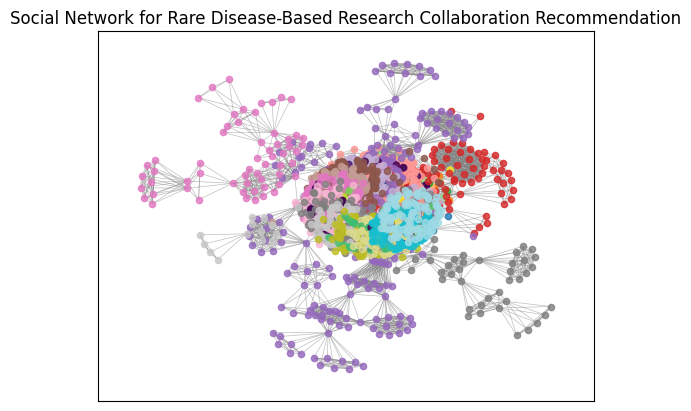

In [105]:
pos = layout_algorithms[-1](G)

# Retrieve the number of communities
num_communities = max(partition.values()) + 1

# Generate a distinct color for each community
color_map = plt.cm.get_cmap('tab20', num_communities)

# Draw nodes and edges
for community_id in range(num_communities):
    nodes_in_community = [node for node, comm in partition.items() if comm == community_id]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_community, node_size=20, node_color=color_map(community_id), alpha=0.8)

nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=0.02)
plt.title("Social Network for Rare Disease-Based Research Collaboration Recommendation")
plt.show()

<ipython-input-112-598df7bedf71>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_communities)
<ipython-input-112-598df7bedf71>:14: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=0.02)


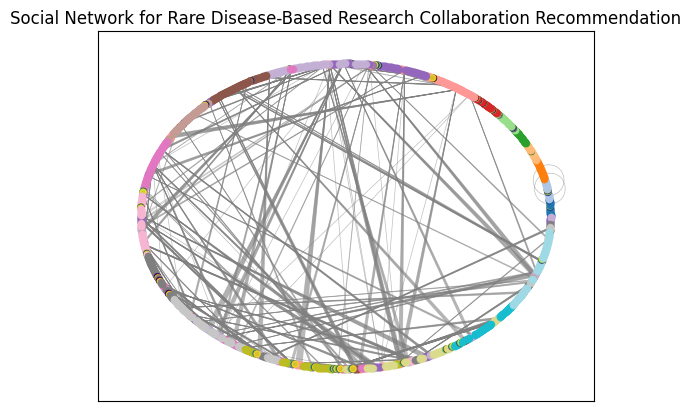

In [112]:
pos = layout_algorithms[0](G)

# Retrieve the number of communities
num_communities = max(partition.values()) + 1

# Generate a distinct color for each community
color_map = plt.cm.get_cmap('tab20', num_communities)

# Draw nodes and edges
for community_id in range(num_communities):
    nodes_in_community = [node for node, comm in partition.items() if comm == community_id]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_community, node_size=20, node_color=color_map(community_id), alpha=0.8)

nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=0.02)
plt.title("Social Network for Rare Disease-Based Research Collaboration Recommendation")
plt.show()

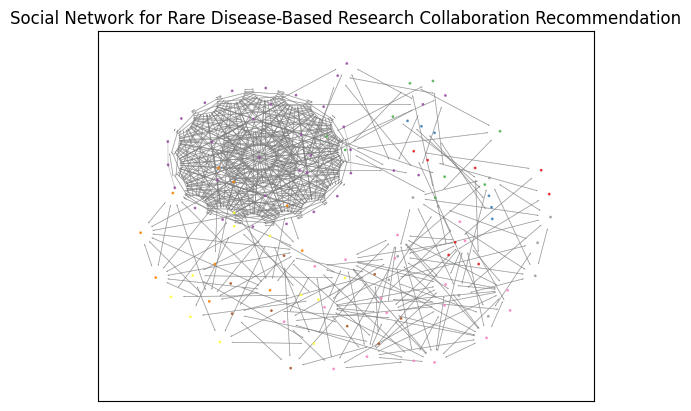

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Your provided dictionary
data = combined_dict
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges from the dictionary
for nodes, edges in data.items():
    G.add_node(nodes[0], institution=nodes[1])
    for edge in edges:
        G.add_node(edge[0], institution=edge[1])
        G.add_edge(nodes[0], edge[0])

# Determine connected components
components = list(nx.strongly_connected_components(G))
# Assign colors to nodes based on connected components
color_map = {}
for i, component in enumerate(components):
    for node in component:
        color_map[node] = plt.cm.Set1(i / len(components))  # Set1 colormap for variety

# Draw the graph with enhanced styling
#fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size

#pos = nx.spring_layout(G, seed=42, k=1, iterations=1)
pos = nx.kamada_kawai_layout(G)

# Node styling with specified colors
node_colors = [color_map[node] for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=1, node_color=node_colors, alpha=0.8)
# Edge styling
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=1)
# Label styling
#labels = {node: f"{node}\n{G.nodes[node]['institution']}" for node in G.nodes}
#nx.draw_networkx_labels(G, pos, labels=labels, font_size=5, font_color='black')
# Add a title
plt.title("Social Network for Rare Disease-Based Research Collaboration Recommendation")
# Show the plot
plt.show()

In [211]:
new_dict = {}
# Iterate through the items of combined_dict and construct the new dictionary
for key, value in combined_dict.items():
    # Simplify the key by taking the second part
    simplified_key = key[1]
    # Simplify the values by taking the second part of each tuple in the list
    simplified_values = [v[1] for v in value]

    # Check if simplified_key already exists in the new dictionary
    if simplified_key in new_dict:
        # If yes, append the new values to the existing list
        new_dict[simplified_key].extend(simplified_values)
    else:
        # If not, initialize a new list with the values
        new_dict[simplified_key] = simplified_values
# Check for repetition in values list and remove values similar to key
for key, values in new_dict.items():
    new_values = []
    for value in values:
        if value != key:  # Check if value is not similar to key
            new_values.append(value)
    # Remove repetition
    new_dict[key] = list(set(new_values))
new_dict = {key: value for key, value in new_dict.items() if value}


In [203]:
dict(list(new_dict.items())[:21])

{'APHP- Hopital Cochin': ['CHRU de Lille / Hôpital Calmette - France'],
 'CHRU de Lille / Hôpital Calmette - France': ['APHP- Hopital Cochin'],
 'Boston Childrens Hospital': ['Johns Hopkins University',
  'Rhode Island Hospital'],
 'Rhode Island Hospital': ['Boston Childrens Hospital'],
 'ICON Early Phase Services (Parts 1 & 2)': ['Medical University of South Carolina (Parts 3 & 4)'],
 'Medical University of South Carolina (Parts 3 & 4)': ['ICON Early Phase Services (Parts 1 & 2)'],
 'Cliniques universitaires Saint-Luc, service de pneumologie': ['University of Health Sciences (HESAV)',
  'School of Gestion and Engineering Vaud (HEIG-VD)',
  'Cliniques universitaires Saint-Luc, service des soins intensifs'],
 'Cliniques universitaires Saint-Luc, service des soins intensifs': ['University of Health Sciences (HESAV)',
  'School of Gestion and Engineering Vaud (HEIG-VD)',
  'Cliniques universitaires Saint-Luc, service de pneumologie'],
 'School of Gestion and Engineering Vaud (HEIG-VD)': [

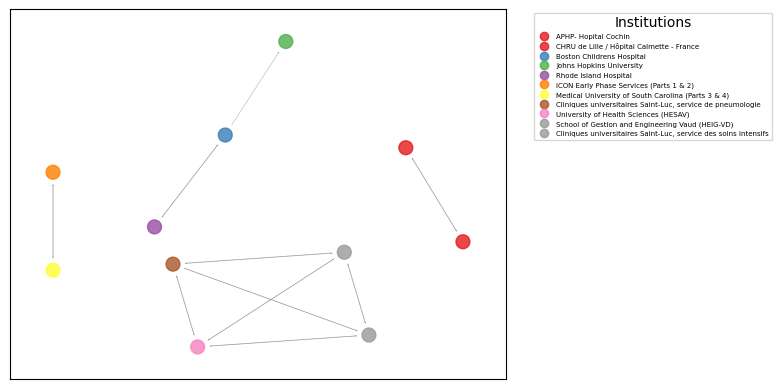

In [235]:
import networkx as nx
import matplotlib.pyplot as plt

# Your provided dictionary
data = dict(list(new_dict.items())[:10])
# Create a directed graph
G = nx.DiGraph()
# Add nodes and edges from the dictionary
for nodes, edges in data.items():
    G.add_node(nodes)
    for edge in edges:
        G.add_node(edge)
        G.add_edge(nodes, edge)

# Generate layout
pos = layout_algorithms[-1](G)

# Generate a list of completely distinct colors for nodes
node_colors = range(len(G.nodes))

# Node styling with specified colors
nodes = nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors, cmap=plt.cm.Set1, alpha=0.8)

# Rest of the code remains the same
nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v in G.edges if u != v], edge_color='gray', width=0.5, alpha=0.5, arrowsize=1)

legend_labels = {node: node for node in G.nodes}

# Create a legend with labels
plt.legend(handles=nodes.legend_elements()[0], labels=list(legend_labels.values()), title='Institutions', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=5)

# Show the plot
plt.show()

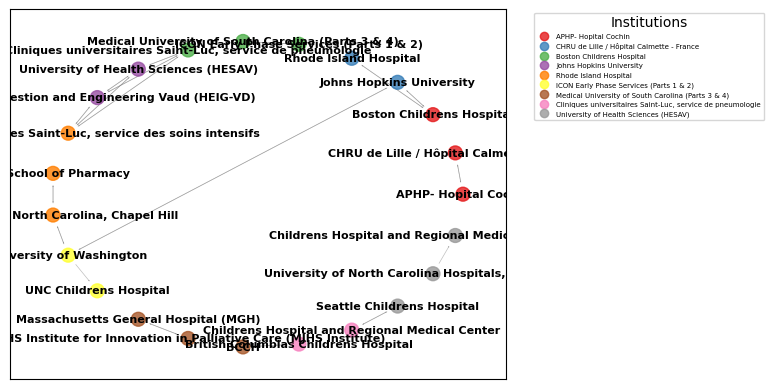

In [232]:
import networkx as nx
import matplotlib.pyplot as plt

# Your provided dictionary
data = dict(list(new_dict.items())[:21])

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges from the dictionary
for nodes, edges in data.items():
    G.add_node(nodes)
    for edge in edges:
        G.add_node(edge)
        G.add_edge(nodes, edge)

# Generate layout
pos = layout_algorithms[0](G)

# Generate a list of completely distinct colors for nodes
node_colors = range(len(G.nodes))

# Node styling with specified colors
nodes = nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors, cmap=plt.cm.Set1, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v in G.edges if u != v], edge_color='gray', width=0.5, alpha=0.5, arrowsize=1)

# Draw labels on top of nodes
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black', font_weight='bold')

# Create a legend with labels
legend_labels = {node: node for node in G.nodes}
plt.legend(handles=nodes.legend_elements()[0], labels=list(legend_labels.values()), title='Institutions', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=5)

# Show the plot
plt.show()

In [233]:
node_colors

range(0, 23)

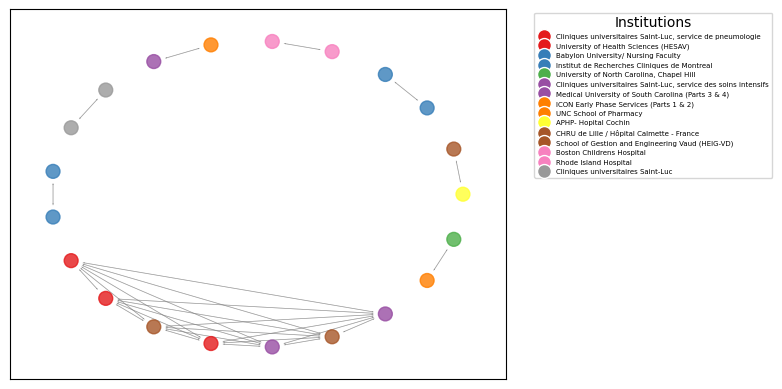

In [190]:
import networkx as nx
import matplotlib.pyplot as plt

# Your provided dictionary
data= dict(list(combined_dict.items())[:21])

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges from the dictionary
for nodes, edges in data.items():
    G.add_node(nodes[0], institution=nodes[1])
    for edge in edges:
        G.add_node(edge[0], institution=edge[1])
        G.add_edge(nodes[0], edge[0])

unique_institutions = set(nx.get_node_attributes(G, 'institution').values())

# Assign colors to nodes based on institutions
color_map = {}
for i, institution in enumerate(unique_institutions):
    nodes_with_institution = [node for node, data in G.nodes(data=True) if data['institution'] == institution]
    for node in nodes_with_institution:
        color_map[node] = plt.cm.Set1(i / len(unique_institutions))
# Draw the graph with enhanced styling
#fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size

# Draw the graph with enhanced styling
#pos = nx.spring_layout(G , seed=42, k=1, iterations=1)
pos = layout_algorithms[0](G)

# Node styling with specified colors
node_colors = [color_map[node] for node in G.nodes]
nodes = nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors, alpha=0.8)
# Rest of the code remains the same
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=1)

# Create a legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.Set1(i / len(unique_institutions)), markersize=10, label=institution) for i, institution in enumerate(unique_institutions)]
plt.legend(handles=legend_handles, title='Institutions', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=5)

# Label styling without displaying the institution names
#labels = {node: node for node in G.nodes}
#nx.draw_networkx_labels(G, pos, labels=labels, font_size=5, font_color='black')

# Show the plot
plt.show()

<ipython-input-183-58164052526c>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_institutions))


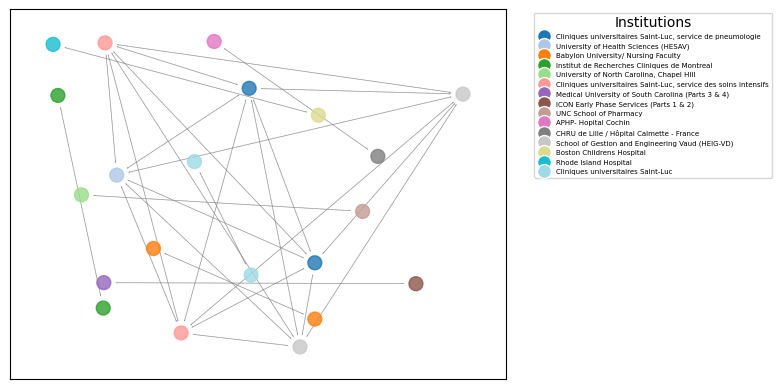

In [183]:

# Define a colormap with enough distinct colors
cmap = plt.cm.get_cmap('tab20', len(unique_institutions))

# Assign colors to nodes based on institutions
color_map = {}
for i, institution in enumerate(unique_institutions):
    nodes_with_institution = [node for node, data in G.nodes(data=True) if data['institution'] == institution]
    for node in nodes_with_institution:
        color_map[node] = cmap(i)

# Draw the graph with enhanced styling
#pos = nx.spring_layout(G, seed=42, k=1, iterations=1)
pos=layout_algorithms[0](G)
# Node styling with specified colors
node_colors = [color_map[node] for node in G.nodes]
nodes = nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors, alpha=0.8)

# Rest of the code remains the same
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5, alpha=0.5, arrowsize=1)

# Create a legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10, label=institution) for i, institution in enumerate(unique_institutions)]
plt.legend(handles=legend_handles, title='Institutions', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=5)

# Show the plot
plt.show()

In [ ]:
def common_keys(dict1, dict2):
    return [key for key in dict1.keys() if key in dict2]

# Example usage
dict1 = {'a': 1, 'b': 2, 'c': 3}
dict2 = {'b': 4, 'c': 5, 'd': 6}

common_keys_list = common_keys(dict1, dict2)
print(common_keys_list)
display(common_keys(a, b))
display(common_keys(a, c))
common_keys(b, c)

['b', 'c']


[]

[]

[]

# Clustring method 2

In [ ]:
display(ClinicalTrial.columns)
display(Grant.columns)
display(Pubmed.columns)

Index(['i.OfficialName', 'i.OfficialAffiliation', 'c. BriefTitle',
       'c.OfficialTitle', 'c.BriefSummary', 'c.NCTId', 'l.LocationCity',
       'l.LocationCountry', 'l.LocationFacility', 'concatenatedInterventions'],
      dtype='object')

Index(['pi.pi_name', 'pi.org_name', 'p.title', 'p.application_id',
       'p.abstract', 'p.terms', 'co.core_project_num'],
      dtype='object')

Index(['a.fullName', 'ar.title', 'ar.affiliation', 'ar.pubmed_id',
       'ar.abstractText', 'concatenatedKeywords', 'concatenatedMeshterms'],
      dtype='object')

In [ ]:
ClinicalTrial['c.BriefSummary']=ClinicalTrial['c.OfficialTitle']+ClinicalTrial['concatenatedInterventions']+ClinicalTrial['c.BriefSummary']
Grant['c.BriefSummary']=Grant['p.title']+Grant['p.terms']+Grant['p.abstract']
Pubmed['ar.abstractText']=Pubmed['ar.title']+Pubmed['concatenatedKeywords']+Pubmed['concatenatedMeshterms']+Pubmed['ar.abstractText']

df1=ClinicalTrial[['i.OfficialName',  'c.BriefSummary', 'i.OfficialAffiliation']]
df2=Grant[['pi.pi_name', 'p.abstract', 'pi.org_name']]
df3=Pubmed[['a.fullName',  'ar.abstractText', 'ar.affiliation']]
# Rename columns to avoid conflicts
df1.columns = ['PI','Abstract', 'Location']
df2.columns = ['PI','Abstract', 'Location']
df3.columns = ['PI','Abstract', 'Location']
#df2['Location']=  df2['locationCity'] +' , '+df2['Location']
result_df = pd.concat([df1, df2, df3])
#result_df = pd.concat([df1,  df3])
result_df=result_df.drop_duplicates()

In [ ]:
result_df

,PI,Abstract,Location
0,Dearbhla Hull,"A Double-blind, Placebo-controlled, Multi-cent...",Zambon SpA
83,Anthony Bier,"A Prospective, Randomized, Double-blinded, Pla...",Nutrasource Pharmaceutical and Nutraceutical S...
84,Mina Pastagia,"A Phase 2, Multi-Center, Double-Blind, Randomi...","Armata Pharmaceuticals, Inc."
91,Mary C. Drinane,Relationship Between the Development of Impair...,Dartmouth-Hitchcock Medical Center
92,Nicolas Roche,Development of a New Tool for Dyspnea Measurem...,APHP- Hopital Cochin
...,...,...,...
33702,Ferrara S,Emerging In Vitro Models for the Study of Infe...,"Department of Biosciences, Università degli St..."
33703,Brignoli T,Emerging In Vitro Models for the Study of Infe...,"Department of Biosciences, Università degli St..."
33704,Baysse C,Pseudomonas aeruginosa Soluble Pyocins as Anti...,"Vrije Universiteit Brussel, Microbiology Group..."
33705,Dingemans J,Pseudomonas aeruginosa Soluble Pyocins as Anti...,"Vrije Universiteit Brussel, Microbiology Group..."


In [177]:
concatenated_data

,Node,Community,PI,Abstract,Location
0,"(Nicolas Roche, APHP- Hopital Cochin)",0,Nicolas Roche,Development of a New Tool for Dyspnea Measurem...,APHP- Hopital Cochin
1,"(Thierry Perez, CHRU de Lille / Hôpital Calmet...",0,Thierry Perez,Development of a New Tool for Dyspnea Measurem...,CHRU de Lille / Hôpital Calmette - France
2,"(Remi Rabasa-Lhoret, Institut de Recherches Cl...",1,Remi Rabasa-Lhoret,Effects of a Program of Aerobic and Resistance...,Institut de Recherches Cliniques de Montreal
3,"(Yves Berthiaume, Institut de Recherches Clini...",1,Yves Berthiaume,Effects of a Program of Aerobic and Resistance...,Institut de Recherches Cliniques de Montreal
4,"(Melissa S Putman, Boston Childrens Hospital)",2,Melissa S Putman,The Effects of a Low Glycemic Load Diet on Dys...,Boston Childrens Hospital
...,...,...,...,...,...
2282,"(Gheerbrant H, Pôle thorax et vaisseaux, clini...",54,Gheerbrant H,[Selection of lung transplant candidates in Fr...,"Pôle thorax et vaisseaux, clinique universitai..."
2283,"(Claustre J, Pôle thorax et vaisseaux, cliniqu...",54,Claustre J,[Selection of lung transplant candidates in Fr...,"Pôle thorax et vaisseaux, clinique universitai..."
2284,"(Okada Y, Department of Physiology and Systems...",55,Okada Y,"Roles of volume-regulatory anion channels, VSO...",Department of Physiology and Systems Bioscienc...
2285,"(Numata T, Department of Physiology and System...",55,Numata T,"Roles of volume-regulatory anion channels, VSO...",Department of Physiology and Systems Bioscienc...


In [ ]:
result_df=result_df[:1000]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
import numpy as np

# Assuming 'abstract' is the column containing abstracts
abstracts = result_df['Abstract'].astype(str)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(abstracts)

# Clustering using DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust parameters as needed
clusters = dbscan.fit_predict(tfidf_matrix)

# Add a new column with the cluster label for each abstract
result_df['Cluster_DBscan'] = clusters
# Number of clusters
num_clusters = len(np.unique(clusters))
print("Number of clusters:", num_clusters)
# Display the DataFrame with the new 'Cluster' column
print(result_df)

Number of clusters: 16
                               PI  \
0                   Dearbhla Hull   
83                   Anthony Bier   
84                  Mina Pastagia   
91                Mary C. Drinane   
92                  Nicolas Roche   
...                           ...   
8237      Stephanie Van Biervliet   
8238              Isabelle Durieu   
8239     Catherine Obrien, Pharmd   
8240  Christine Rousset Jablonski   
8241           Ian M Balfour Lynn   

                                               Abstract  \
0     A Double-blind, Placebo-controlled, Multi-cent...   
83    A Prospective, Randomized, Double-blinded, Pla...   
84    A Phase 2, Multi-Center, Double-Blind, Randomi...   
91    Relationship Between the Development of Impair...   
92    Development of a New Tool for Dyspnea Measurem...   
...                                                 ...   
8237  Can Quantitative Ultrasound be Used for the Ev...   
8238  Long Term Effects of Azithromycin in Patients ...   
8

In [ ]:
!pip install top2vec
!pip install top2vec[sentence_encoders]

In [ ]:
from top2vec import Top2Vec

# Assuming 'abstract' is the column containing abstracts
abstracts = result_df['Abstract'].astype(str).tolist()
# Initialize Top2Vec model
top2vec_model = Top2Vec(documents=abstracts, speed="fast-learn", workers=4)  #embedding_model='universal-sentence-encoder'
# Get document embeddings
document_vectors = top2vec_model.documents
num_topics = top2vec_model.get_num_topics()
topics = top2vec_model.get_topics()
#top2vec_model.topic_words
#top2vec_model.generate_topic_wordcloud(0)


2024-02-13 23:53:33,631 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-02-13 23:53:34,068 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2024-02-13 23:53:36,420 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-02-13 23:54:24,245 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2024-02-13 23:54:36,640 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2024-02-13 23:54:36,709 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


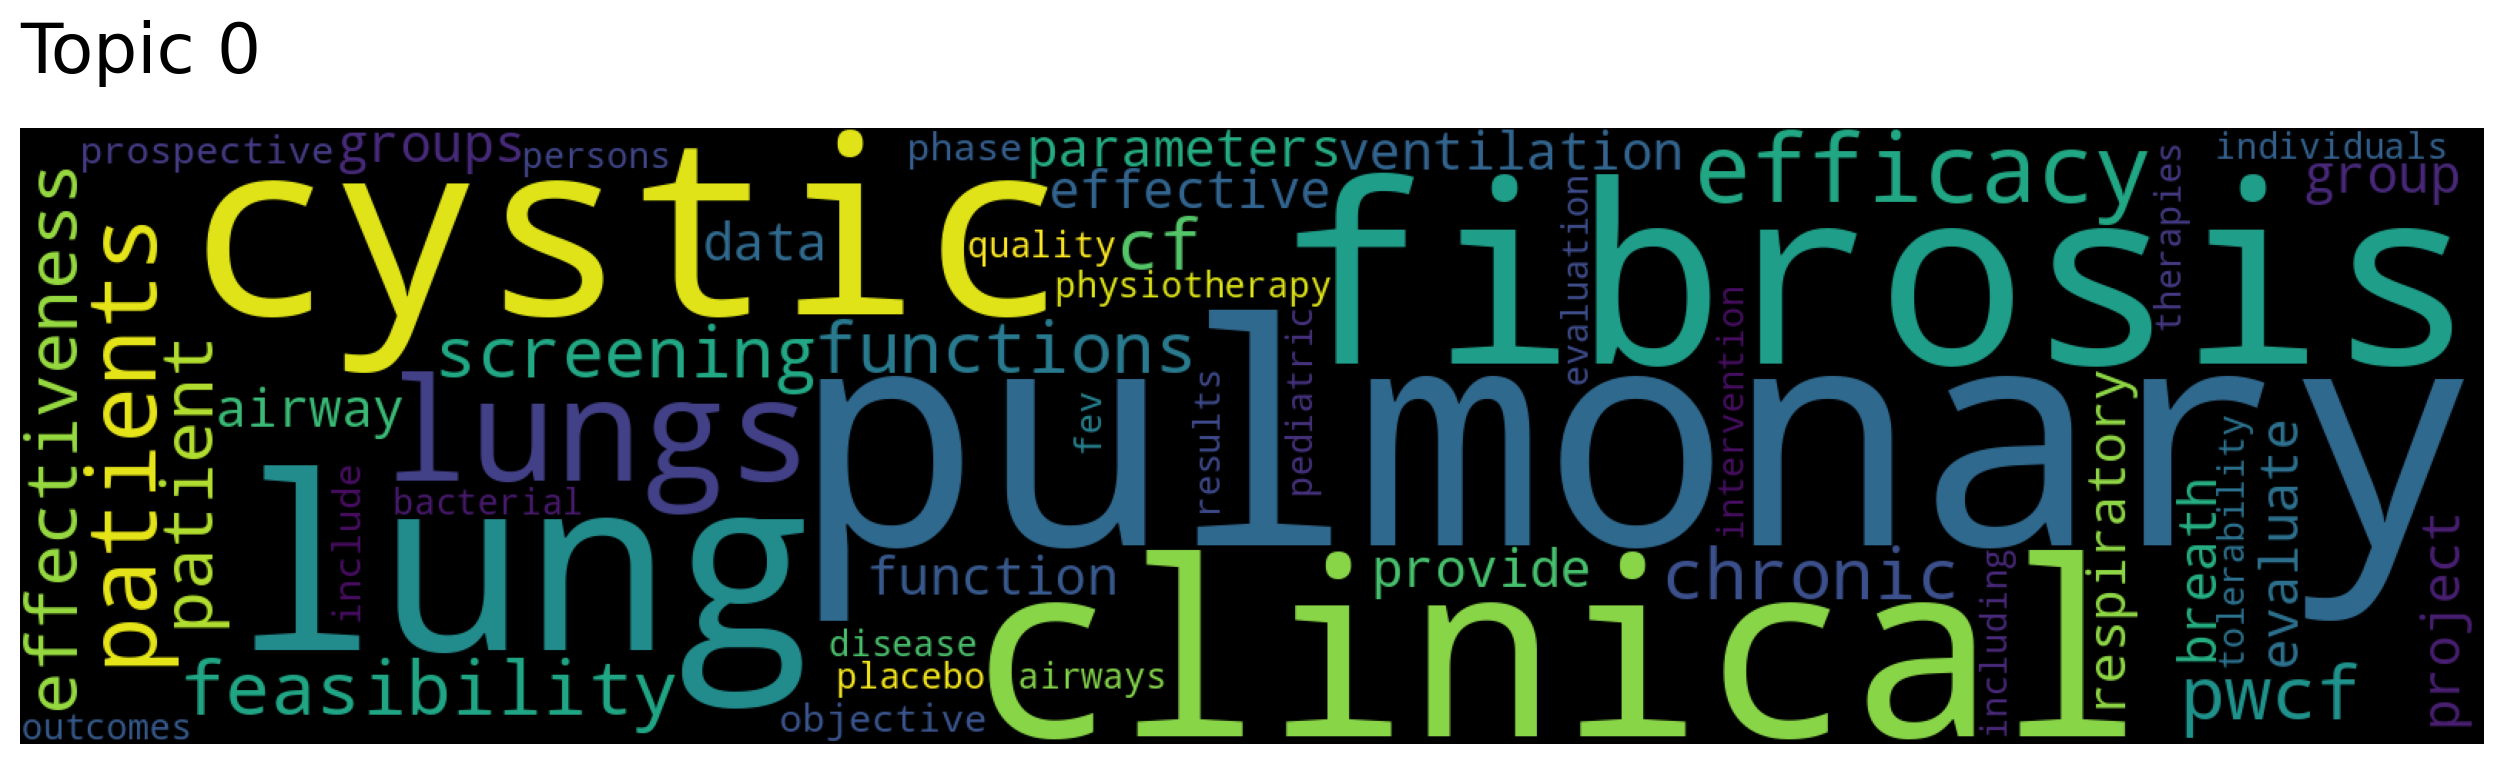

In [ ]:
top2vec_model.generate_topic_wordcloud(0)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# Assuming 'abstract' is the column containing abstracts
abstracts = result_df['Abstract'].astype(str)
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(abstracts)
# Topic Modeling using Latent Dirichlet Allocation (LDA)
num_topics = 10  # Adjust the number of topics as needed
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
topic_matrix = lda_model.fit_transform(tfidf_matrix)
# Add a new column with the related topic for each abstract
result_df['Topic'] = topic_matrix.argmax(axis=1)
# Display the DataFrame with the new 'Topic' column
result_df[550:587]

<ipython-input-227-a090a2d920b1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['Topic'] = topic_matrix.argmax(axis=1)


,PI,Title,Abstract,Location,Topic,cluster
4332,"Eckhard Schoenau, Prof",Cystic Fibrosis: Improvement of Muscle Force a...,The purpose of this study is to evaluate the e...,"University Children´s Hospital Cologne, Germany",9,9
4333,"Andres Floto, Mrcp","A Home-based, Rapid and Quantitative Test for ...",To identify whether home monitoring of multipl...,Papworth Hospital NHS Foundation Trust,9,5
4334,Eitan Kerem,"Single-site, Open-label, Dose-ranging, Efficac...",Working Hypothesis: EGCG and Tocotrienol can a...,Hadassah Medical Organization,2,5
4335,"Karolinne Monteiro, Master",Effects of Aerobic Interval Training on Glucos...,The purpose of this study is to investigate th...,Universidade Federal do Rio Grande do Norte,0,9
4336,Mark Montgomery,A Phase IIa Open Label Study to Evaluate the S...,"This is a single center, open label, Phase IIa...",University of Calgary,8,8
4339,Shawn Aaron,Treatment of Aspergillus Fumigatus in Patients...,This clinical trial will attempt to determine ...,OHRI,9,5
4341,Nestor A. Molfino,"A Phase I/II Randomized, Double-Blind, Placebo...",The primary objective of this study is to eval...,"Humanigen, Inc.",9,1
4352,Carlos Milla,"A Phase I/II Randomized, Double-Blind, Placebo...",The primary objective of this study is to eval...,Stanford University,9,1
4363,Bonnie S Slovis,Phase 1 Study of Hydroxychloroquine in Cystic ...,Study levels of inflammatory mediators in indu...,Vanderbilt University,9,5
4364,Adelaida Lamas,Phase 4 Study of the Efficacy of Long-term Tre...,"A phase IV clinical trial, multicentric (3 Hos...",nan,0,1


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

def name_clusters(df, text_column, cluster_column, num_clusters=5):
    # Extract abstracts from the specified column
    abstracts = df[text_column].tolist()

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(abstracts)

    # KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(tfidf_matrix)

    # Assign cluster labels to the DataFrame
    df[cluster_column] = clusters

    # Extract most important words for each cluster
    terms = vectorizer.get_feature_names_out()
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

    cluster_names = {}
    for i in range(num_clusters):
        important_words = [terms[ind] for ind in order_centroids[i, :5]]  # Extract top 5 words per cluster
        cluster_names[i] = ' '.join(important_words)

    # Rename the columns based on cluster names
    column_names = {i: f'Topic_{i}_{cluster_names[i]}' for i in range(num_clusters)}
    df.rename(columns=column_names, inplace=True)

    return df
df=result_df
name_clusters(df, 'Abstract', 'cluster', num_clusters=10)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-226-f2cd3826a201>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cluster_column] = clusters
<ipython-input-226-f2cd3826a201>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=column_names, inplace=True)


,PI,Title,Abstract,Location,Topic,cluster
0,Dearbhla Hull,"A Double-blind, Placebo-controlled, Multi-cent...",The primary objective of the trial is to inves...,Zambon SpA,2,1
89,Anthony Bier,"A Prospective, Randomized, Double-blinded, Pla...",This study aims to evaluate the impact of a sp...,Nutrasource Pharmaceutical and Nutraceutical S...,3,9
90,Mina Pastagia,"A Phase 2, Multi-Center, Double-Blind, Randomi...","A phase 2, multi-center, double-blind, randomi...","Armata Pharmaceuticals, Inc.",2,1
97,Mary C. Drinane,Relationship Between the Development of Impair...,This study proposes to examine the relationshi...,Dartmouth-Hitchcock Medical Center,3,9
98,Nicolas Roche,Development of a New Tool for Dyspnea Measurem...,The purpose of this study is the psychometric ...,APHP- Hopital Cochin,3,5
...,...,...,...,...,...,...
7854,Medical Monitor,"A Randomized, Double-Blind, Placebo-Controlled...",The primary objective of the study was to eval...,Vertex Pharmaceuticals Incorporated,2,8
7879,"Raphael Chiron, Pu-Ph",Multi-omic Longitudinal Characterization of Pu...,The composition and role of the pulmonary micr...,University Hospitals of Montpellier,3,5
7880,"Asad Patanwalla, Pharmd",Modifying Genes in Cystic Fibrosis: The Beta-2...,Our aims were to determine if exhaled breath c...,"Department of Pharmacy Practice and Science, U...",3,5
7881,"Hanna Phan, Pharmd",Modifying Genes in Cystic Fibrosis: The Beta-2...,Our aims were to determine if exhaled breath c...,"Department of Pharmacy Practice and Science, U...",3,5


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd


def extract_topics_lda(text, num_topics=2):
    # Tokenize the text
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform([text])

    # Apply LDA
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)

    # Get the most probable topics
    feature_names = vectorizer.get_feature_names_out()
    topics = [', '.join([feature_names[i] for i in topic.argsort()[:-num_topics - 1:-1]]) for topic in lda.components_]

    return topics


def extract_topics_lda_grouped(df):
    # Group by 'Topic' and sum 'Abstract'
    grouped_df = df.groupby('Topic')['Abstract'].sum().reset_index()

    # Initialize an empty list to store the results for each topic
    results = []

    # Apply LDA to each grouped abstract
    for index, row in grouped_df.iterrows():
        topic = row['Topic']
        abstract = row['Abstract']

        # Tokenize and apply LDA
        topics_found = extract_topics_lda(abstract)

        # Append the result to the list
        results.append({'Topic': topic, 'Topics_found': topics_found})

    return results


# Function call
grouped_results = extract_topics_lda_grouped(result_df)

# Display results
for result in grouped_results:
    print(f"Topic {result['Topic']}: {result['Topics_found']}")

Topic 0: ['study, patients', 'study, patients']
Topic 1: ['study, cf', 'study, cf']
Topic 2: ['cf, patients', 'cf, patients']
Topic 3: ['patients, transplantation', 'patients, transplantation']
Topic 4: ['cf, patients', 'cf, patients']
Topic 5: ['cf, study', 'cf, study']
Topic 6: ['study, patients', 'study, patients']
Topic 7: ['cf, cystic', 'cf, cystic']
Topic 8: ['study, fibrosis', 'study, fibrosis']
Topic 9: ['cf, study', 'cf, study']


In [ ]:
from transformers import pipeline
def ask_question(question, context):
    # Load the pretrained question-answering model
    qa_pipeline = pipeline("question-answering", model="bert-large-uncased-whole-word-masking-finetuned-squad")

    # Provide the context and question to the model
    answer = qa_pipeline(question=question, context=context)

    return answer['answer']

# Example usage
context = '''Edson Arantes do Nascimento (Brazilian Portuguese: [ˈɛtsõ aˈɾɐ̃tʃiz du nasiˈmẽtu]; 23 October 1940 – 29 December 2022), better known by his nickname Pelé (Portuguese pronunciation: [peˈlɛ]), was a Brazilian professional footballer who played as a forward. Widely regarded as one of the greatest players of all-time, he was among the most successful and popular sports figures of the 20th century.[2][3] In 1999, he was named Athlete of the Century by the International Olympic Committee and was included in the Time list of the 100 most important people of the 20th century. In 2000, Pelé was voted World Player of the Century by the International Federation of Football History & Statistics (IFFHS) and was one of the two joint winners of the FIFA Player of the Century. His 1,279 goals in 1,363 games, which includes friendlies, is recognised as a Guinness World Record.[4]'''
#question = "what word can describe this text"
question = "what are the main skills?"
ask_question(question, context)


NameError: name 'pipeline' is not defined

https://thenewstack.io/large-language-models-open-source-llms-in-2023/

In [ ]:
from transformers import pipeline
qa_pipeline = pipeline("question-answering", model="bert-large-uncased-whole-word-masking-finetuned-squad")
def ask_question(context):
    # Load the pretrained question-answering model
    # Provide the context and question to the model
    answer = qa_pipeline(question="what are the main skills?", context=context)

    return answer['answer']
def extract_topics_lda_grouped(df):
    # Group by 'Topic' and sum 'Abstract'
    grouped_df = df.groupby('Topic')['Abstract'].sum().reset_index()

    # Initialize an empty list to store the results for each topic
    results = []

    # Apply LDA to each grouped abstract
    for index, row in grouped_df.iterrows():
        topic = row['Topic']
        abstract = row['Abstract']

        # Tokenize and apply LDA
        topics_found = ask_question(abstract)

        # Append the result to the list
        results.append({'Topic': topic, 'Topics_found': topics_found})

    return results
# Function call
grouped_results = extract_topics_lda_grouped(result_df)

# Display results
for result in grouped_results:
    print(f"Topic {result['Topic']}: {result['Topics_found']}")

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trai

Topic 0: Assess the safety and the tolerability of NO intermittent inhalation treatment
Topic 1: feasibility and tolerability
Topic 2: self-care skills (knowledge and skills) and coping skills
Topic 3: Assess gestural know-how
Assess the cognitive know-how
Topic 4: education, as well as nutritional and exercise counselling
Topic 5: physiotherapy and inhalation
Topic 6: CF knowledge and skills
Topic 7: chest physiotherapy (\chest PT\) and cough
Topic 8: patient, catheter, and catheter management
Topic 9: feasibility and discriminative value


<ipython-input-230-da9abf8fb6a6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df1['Topic'] = result_df1['Topic'].astype(int)  # Convert 'Topic' to integer for labeling


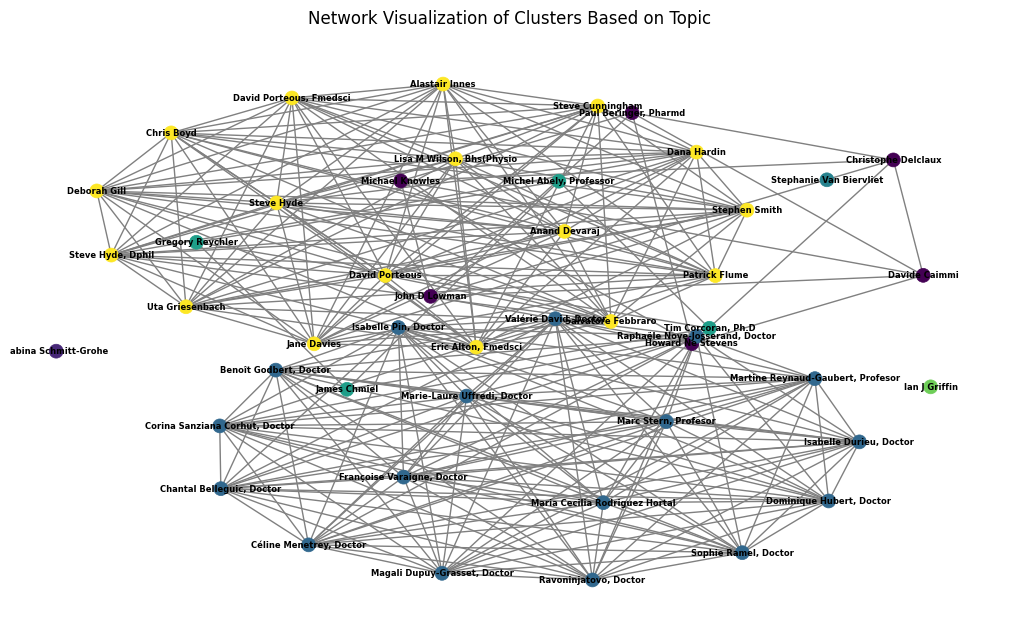

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Assuming 'result_df' is your DataFrame
result_df1 = result_df[650:700]
result_df1['Topic'] = result_df1['Topic'].astype(int)  # Convert 'Topic' to integer for labeling

# Create a graph
G = nx.Graph()

# Add nodes (Principal Investigators) with colors based on 'Topic'
node_colors = {}
for index, row in result_df1.iterrows():
    G.add_node(row['PI'])
    node_colors[row['PI']] = row['Topic']

# Add edges based on 'Topic'
for index, row in result_df1.iterrows():
    neighbors = result_df1[result_df1['Topic'] == row['Topic']]['PI']
    for neighbor in neighbors:
        if neighbor != row['PI']:  # Avoid self-loops
            G.add_edge(row['PI'], neighbor)

# Draw the graph with node colors and increased distance
plt.figure(figsize=(10, 6))
#pos = nx.spring_layout(G, k=1.2)  # Adjust the value of k for increased distance
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, font_size=6, node_size=100, node_color=[node_colors[node] for node in G.nodes], cmap='viridis', font_color='black', font_weight='bold', edge_color='gray', linewidths=0.5)

# Set plot title
plt.title('Network Visualization of Clusters Based on Topic')

# Show the plot
plt.show()

<ipython-input-231-e5a452a5677d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df1['Topic'] = result_df1['Topic'].astype(int)  # Convert 'Topic' to integer for labeling


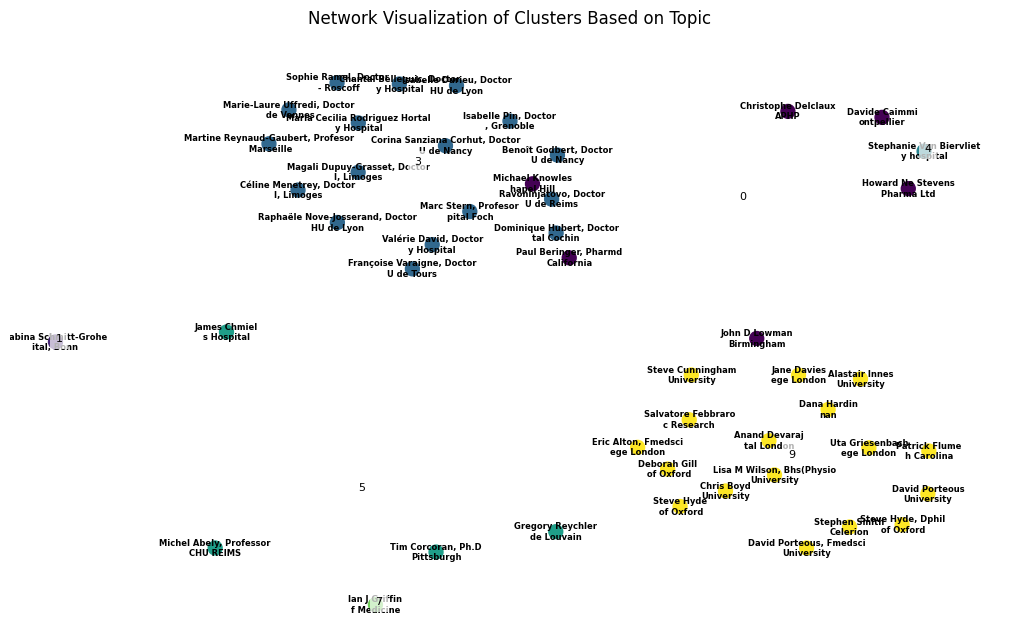

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Assuming 'result_df' is your DataFrame
result_df1 = result_df[650:700]
result_df1['Topic'] = result_df1['Topic'].astype(int)  # Convert 'Topic' to integer for labeling

# Create a graph
G = nx.Graph()

# Add nodes (Principal Investigators) with colors based on 'Topic'
node_labels = {}
node_colors = {}
for index, row in result_df1.iterrows():
    G.add_node(row['PI'])
    node_colors[row['PI']] = row['Topic']
    location_info = row['Location'][-10:]  # Take the last 10 characters of the 'Location'
    node_labels[row['PI']] = f"{row['PI']}\n{location_info}"  # Custom label including 'PI' and 'Location'

# Add edges
for index, row in result_df1.iterrows():
    neighbors = result_df1[result_df1['Topic'] == row['Topic']]['PI']
    for neighbor in neighbors:
        if neighbor != row['PI']:  # Avoid self-loops
            G.add_edge(row['PI'], neighbor)

# Draw the graph with node colors and labels for each cluster
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, k=1)  # Adjust the value of k for increased distance
nx.draw(G, pos, with_labels=True, font_size=6, node_size=100,
        node_color=[node_colors[node] for node in G.nodes], cmap='viridis', font_color='black', font_weight='bold',
        edge_color='white', labels=node_labels)  # Set the edge color to white and use custom labels

# Add labels for each cluster
cluster_labels = {label: label for label in set(node_colors.values())}
for color, label in cluster_labels.items():
    cluster_nodes = [node for node, node_color in node_colors.items() if node_color == color]
    cluster_center = (sum(pos[node][0] for node in cluster_nodes) / len(cluster_nodes),
                      sum(pos[node][1] for node in cluster_nodes) / len(cluster_nodes))
    plt.text(cluster_center[0], cluster_center[1], label, fontsize=8, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Set plot title
plt.title('Network Visualization of Clusters Based on Topic')

# Show the plot
plt.show()

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification

def get_important_words(text):
    # Load pretrained model and tokenizer
    model_name = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(model_name)

    # Tokenize input text
    tokens = tokenizer(text, return_tensors="pt")

    # Get model output
    outputs = model(**tokens)

    # Choose relevant layer for embeddings (e.g., logits for BERT token classification)
    logits = outputs.logits

    # Calculate importance scores (e.g., sum of logits)
    importance_scores = logits.sum(dim=1)

    # Get the top 10 important words
    top_words_indices = importance_scores.argsort(descending=True)[:, :10]

    # Decode tokens back to words
    important_words = [tokenizer.decode(indices.tolist(), skip_special_tokens=True) for indices in top_words_indices]

    return important_words

# Example usage
text_to_analyze = '''In natural language processing, the identification of key words within
a text is a crucial task for understanding content and extracting meaningful information.
Leveraging the power of pretrained language models, we have developed a Python function named get_important_words.
 This function utilizes the BERT-based model, specifically bert-base-uncased, and employs the Hugging Face
  Transformers library. By tokenizing the input text and obtaining the model's predictions through
   the logits attribute, the function calculates importance scores for each word.
    The top 10 important words are then extracted based on these scores.
    To demonstrate the functionality, we applied the function to the sample text
     and obtained the important words. This approach allows
    for a quick and effective way to identify key terms within a given text,
    facilitating tasks such as content summarization, keyword extraction, and more.'''
important_words = get_important_words(text_to_analyze)
print("Important words:", important_words)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Important words: ['[unused0]']


In [ ]:
#!pip install transformers
#!pip install accelerate
#TRANSFORM=`python -c "import transformers;print('/'.join(transformers.__file__.split('/')[:-1])+'/models/llama/convert_llama_weights_to_hf.py')"`
!pip install protobuf && python $TRANSFORM --input_dir ./llama-2-7b-chat --model_size 7B --output_dir ./llama-2-7b-chat-hf

unknown option --input_dir
usage: python3 [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.


In [ ]:
import torch
import transformers
from transformers import LlamaForCausalLM, LlamaTokenizer

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Answer: forward
